# QSudoku Demo: Basic Workflow

This notebook demonstrates the basic workflow of the quantum Sudoku solving framework, focusing on the main class `QSudoku`.

## Basic Workflow Steps:
1. **Puzzle Creation** - Generate or load a Sudoku puzzle
2. **Solver Setup** - Configure the quantum solving algorithm  
3. **Circuit Building** - Build the quantum circuit
4. **Execution** - Run the quantum algorithm

In [1]:
# Import the main QSudoku class
from sudoku_nisq import QSudoku

## Step 1: Puzzle Creation

Let's generate a simple 4x4 Sudoku puzzle with 2 missing cells.

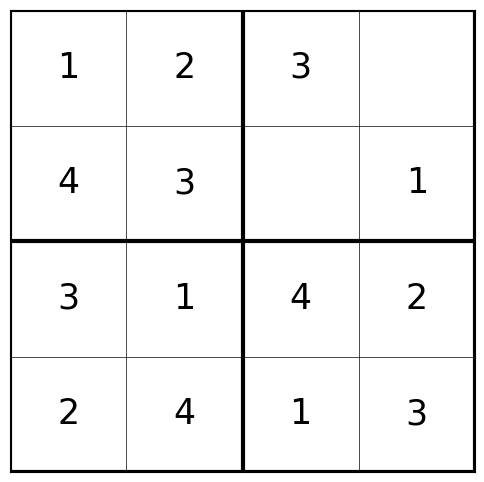

In [2]:
# Generate a 4x4 Sudoku puzzle with 2 missing cells
# subgrid_size=2 means 2x2 subgrids, creating a 4x4 puzzle

sudoku = QSudoku.generate(
  subgrid_size=2,
  num_missing_cells=2)

# Display the generated puzzle
sudoku.plot_puzzle()

## Step 2: Solver Setup

Now we'll configure the quantum solving algorithm. We'll use the `ExactCoverQuantumSolver` with the "simple" encoding.

In [3]:
# Set the quantum solving algorithm
from sudoku_nisq.exact_cover_solver import ExactCoverQuantumSolver

sudoku.set_solver(ExactCoverQuantumSolver, encoding="simple")

## Step 3: Circuit Building

Build the quantum circuit that implements the exact cover algorithm for our puzzle.

In [4]:
# Build the quantum circuit for the puzzle
circuit = sudoku.build_circuit()

# Display circuit information

print(f"Circuit qubits: {circuit.n_qubits}")
print(f"Circuit gates: {circuit.n_gates}")
print(f"Circuit depth: {circuit.depth()}")

Circuit qubits: 11
Circuit gates: 32
Circuit depth: 16


In [5]:
sudoku.draw_circuit()

## Step 4: Execution

Now we can run our quantum circuit. We'll use the Aer simulator for this demo.

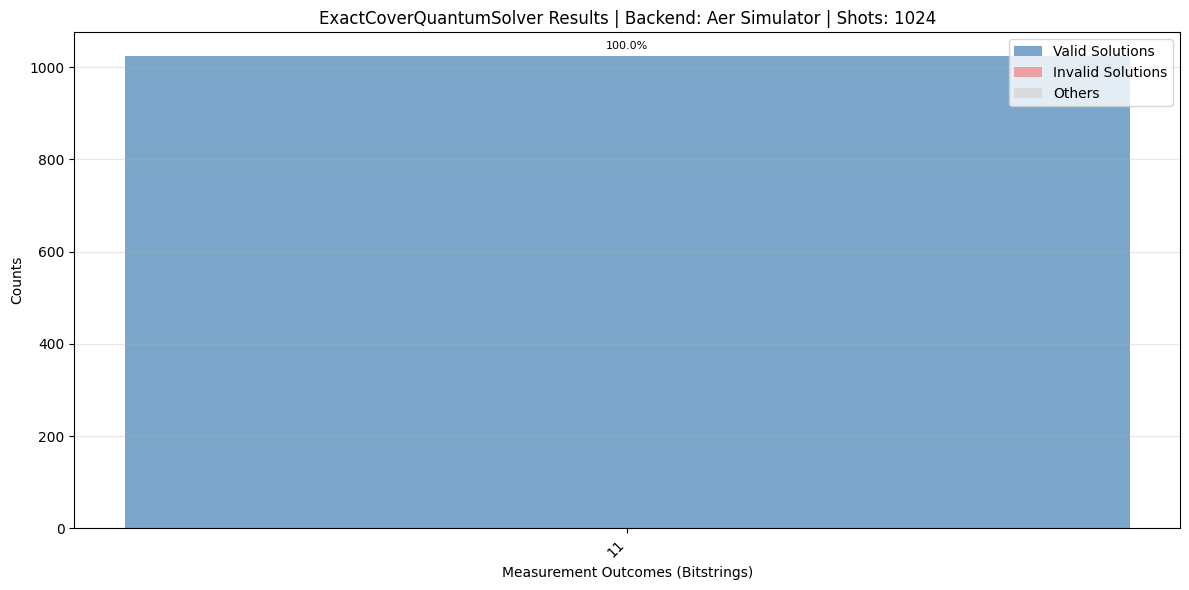


Summary:
Total unique outcomes: 1
Total shots: 1024
Valid solutions found: 1024 (100.00%)
Most frequent outcome: 11 (100.00%)


In [6]:
# Run on the Aer simulator and visualize results
result = sudoku.run_aer(shots=1024)

# Use the new counts_plot method to visualize results
sudoku.counts_plot(result, backend_alias="Aer Simulator", shots=1024)

## Summary

We've successfully demonstrated the basic QSudoku workflow:

1. ✅ **Generated** a 4x4 Sudoku puzzle
2. ✅ **Configured** the ExactCoverQuantumSolver
3. ✅ **Built** the quantum circuit
4. ✅ **Executed** on the Aer simulator

The framework automatically handles:
- Circuit caching and optimization
- Error handling and validation  
- Metadata collection and logging
- Memory management